## Import libraries

In [127]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import joblib
import seaborn as sns  
from sklearn.metrics import mean_squared_error

## Display results Latex table

In [128]:
results = pd.read_csv('results.csv')
results['RMSE'] = round(results['RMSE'], 2)

In [130]:
def create_fancy_latex_table(df):
    # Pivot the data as before
    ph6_data = df[df['Prediction Horizon'] == 6].pivot(index='Patient', columns='Approach', values='RMSE')
    ph12_data = df[df['Prediction Horizon'] == 12].pivot(index='Patient', columns='Approach', values='RMSE')

    # Get the mean and standard deviation
    ph6_mean = ph6_data.mean()
    ph6_std = ph6_data.std()
    ph12_mean = ph12_data.mean()
    ph12_std = ph12_data.std()

    # Build the LaTeX table
    latex = [
        "\\begin{table}",
        "\\caption{Comparison of RMSE Values Between GPT4O and NoLLM Approaches}",
        "\\label{tab:rmse_comparison}",
        "\\centering",
        "\\renewcommand{\\arraystretch}{1.3}",
        "\\begin{tabular}{|l|cc|cc|}",
        "\\hline",
        "\\rowcolor{gray!20} \\multirow{1}{*}{\\textbf{Patient}} & \\multicolumn{2}{c|}{\\textbf{PH 30}} & \\multicolumn{2}{c|}{\\textbf{PH 60}} \\\\[+0.5ex]",
        "\\rowcolor{gray!20} & \\textbf{GPT4O} & \\textbf{NoLLM} & \\textbf{GPT4O} & \\textbf{NoLLM} \\\\[-1.5ex]",
        "\\hline"
    ]

    # Add each patient's data
    for i, patient in enumerate(sorted(ph6_data.index)):
        if i % 2 == 0:
            latex.append("\\rowcolor{gray!10}")
        row = (f"\\textbf{{{patient}}} & "
               f"{ph6_data.loc[patient, 'gpt4o']:.2f} & {ph6_data.loc[patient, 'nollm']:.2f} & "
               f"{ph12_data.loc[patient, 'gpt4o']:.2f} & {ph12_data.loc[patient, 'nollm']:.2f} \\\\")
        latex.append(row)
        latex.append("\\hline")

    # Add the mean ± std row
    latex.extend([
        "\\rowcolor{gray!20}",
        f"\\textbf{{Mean $\\pm$ STD}} & "
        f"{ph6_mean['gpt4o']:.2f}$\\pm${ph6_std['gpt4o']:.2f} & {ph6_mean['nollm']:.2f}$\\pm${ph6_std['nollm']:.2f} & "
        f"{ph12_mean['gpt4o']:.2f}$\\pm${ph12_std['gpt4o']:.2f} & {ph12_mean['nollm']:.2f}$\\pm${ph12_std['nollm']:.2f} \\\\",
        "\\hline",
        "\\end{tabular}",
        "\\end{table}"
    ])

    # Join all lines into a single string
    latex_content = '\n'.join(latex)

    # Save the LaTeX content to a .tex file
    with open('latex_tables/rmse_comparison_table.tex', 'w') as f:
        f.write(latex_content)

    return latex_content
create_fancy_latex_table(results)

'\\begin{table}\n\\caption{Comparison of RMSE Values Between GPT4O and NoLLM Approaches}\n\\label{tab:rmse_comparison}\n\\centering\n\\renewcommand{\\arraystretch}{1.3}\n\\begin{tabular}{|l|cc|cc|}\n\\hline\n\\rowcolor{gray!20} \\multirow{1}{*}{\\textbf{Patient}} & \\multicolumn{2}{c|}{\\textbf{PH 30}} & \\multicolumn{2}{c|}{\\textbf{PH 60}} \\\\[+0.5ex]\n\\rowcolor{gray!20} & \\textbf{GPT4O} & \\textbf{NoLLM} & \\textbf{GPT4O} & \\textbf{NoLLM} \\\\[-1.5ex]\n\\hline\n\\rowcolor{gray!10}\n\\textbf{1} & 16.46 & 17.24 & 33.00 & 36.58 \\\\\n\\hline\n\\textbf{2} & 20.67 & 20.60 & 44.67 & 43.69 \\\\\n\\hline\n\\rowcolor{gray!10}\n\\textbf{4} & 24.36 & 24.84 & 50.16 & 51.29 \\\\\n\\hline\n\\textbf{6} & 15.22 & 15.32 & 30.54 & 29.98 \\\\\n\\hline\n\\rowcolor{gray!10}\n\\textbf{7} & 18.22 & 19.48 & 30.76 & 32.30 \\\\\n\\hline\n\\textbf{8} & 18.64 & 18.26 & 37.60 & 35.97 \\\\\n\\hline\n\\rowcolor{gray!20}\n\\textbf{Mean $\\pm$ STD} & 18.93$\\pm$3.25 & 19.29$\\pm$3.27 & 37.79$\\pm$8.07 & 38.30$\

## Investigate performance differences between patients

In [131]:
def find_patients_with_lowest_rmse(df, ph):
    df = df[df['Prediction Horizon']==ph]
    pivot_df = df.pivot(index='Patient', columns='Approach', values='RMSE')
    
    # Find patients where "nollm" has the lowest RMSE
    patients_with_lowest_rmse = pivot_df.idxmin(axis=1)
    return patients_with_lowest_rmse[patients_with_lowest_rmse == 'nollm'].index.tolist()

for ph in [6, 12]:
    patients_with_lowest_rmse = find_patients_with_lowest_rmse(results, ph)
    print(f"Patients where 'nollm' has the lowest RMSE at PH {ph}:", patients_with_lowest_rmse)

Patients where 'nollm' has the lowest RMSE at PH 6: [2, 8]
Patients where 'nollm' has the lowest RMSE at PH 12: [2, 6, 8]


## Investigate whether glucose and food data differ between patients

In [132]:
def plot_timeline_with_predictions(ground_truth, datetime, y_preds, approaches):  

    # Combining dataframes
    data_ground_truth = pd.DataFrame({  
        'Datetime': datetime,  
        'Glucose Level': ground_truth,  
        'Type': 'Ground Truth'  
    })  
    all_data_predictions = []  
    for approach in approaches:  
        data_predictions = pd.DataFrame({  
            'Datetime': datetime,  
            'Glucose Level': y_preds[approach],  
            'Type': f'Prediction {approach}'  
        })  
        all_data_predictions.append(data_predictions)  
    data_combined = pd.concat([data_ground_truth] + all_data_predictions, ignore_index=True)  
    data_combined['Datetime'] = pd.to_datetime(data_combined['Datetime'])  
    data_combined['Time'] = data_combined['Datetime'].dt.strftime('%H:%M')  
      
    # Plotting  
    sns.set_theme(style="whitegrid")  
    plt.figure(figsize=(12, 6))  
    sns.lineplot(data=data_combined[data_combined['Type'] == 'Ground Truth'],  
                 x='Time',  
                 y='Glucose Level',  
                 label='Ground Truth',  
                 color='#1f77b4',  
                 alpha=1.0)  
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  
    for i, approach in enumerate(approaches):  
        sns.lineplot(data=data_combined[data_combined['Type'] == f'Prediction {approach}'],  
                     x='Time',  
                     y='Glucose Level',  
                     label=f'Prediction {approach}',  
                     color=colors[i],  
                     alpha=0.7)  
      
    plt.xlabel("Time", fontsize=12)  
    plt.ylabel("Glucose Level (mg/dL)", fontsize=12)  
    plt.xticks(rotation=45, fontsize=10)  
    plt.yticks(fontsize=10)  
    plt.legend(fontsize=10)  
      
    # Adjusting x-axis tick frequency  
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  
      
    plt.tight_layout()  
    plt.show()  

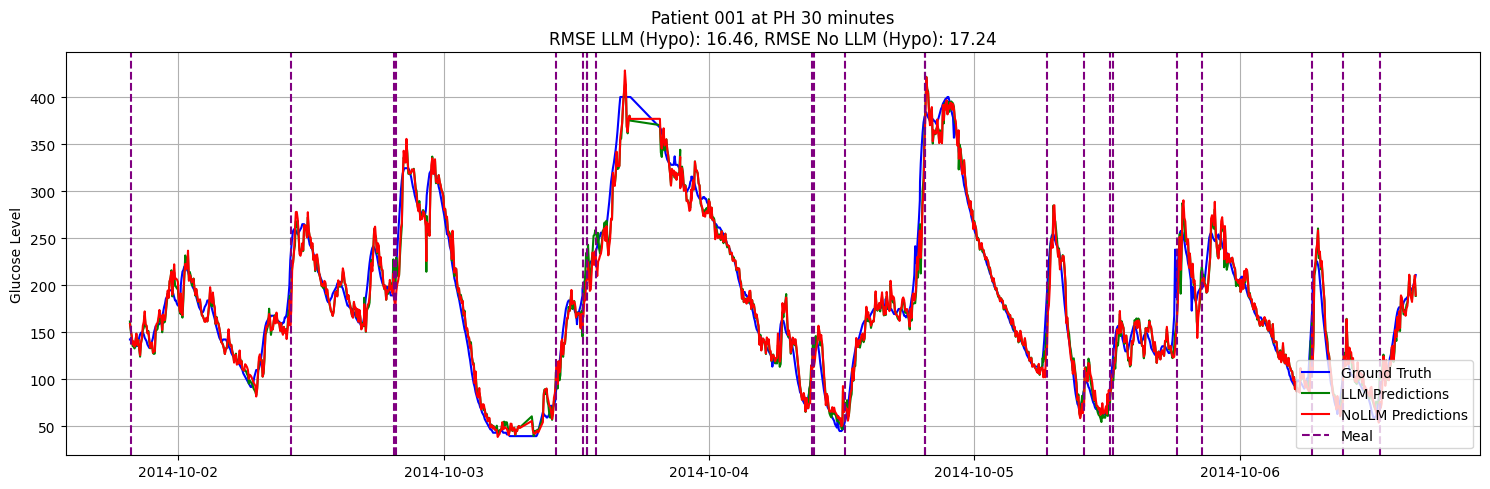

All plots have been saved as PNG files.


In [133]:
patient = '001'
prediction_horizon = 6
approaches = ['gpt4o', 'nollm']


food_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

insulin_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
insulin_data['datetime'] = pd.to_datetime(insulin_data['datetime'], format='%Y:%m:%d %H:%M:%S')

approach = 'nollm'
nollm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_predictions.csv")
approach = 'gpt4o'
llm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_predictions.csv")

start_idx = 0
end_idx = len(llm_preds)
selected_idx = list(range(start_idx, end_idx))
llm_preds = llm_preds.iloc[selected_idx, :]
nollm_preds = nollm_preds.iloc[selected_idx, :]

nollm_preds['Datetime'] = pd.to_datetime(nollm_preds['Datetime'])

plt.figure(figsize=(15, 5))

# Plot Ground Truth
plt.plot(nollm_preds['Datetime'], nollm_preds['Ground_truth'], label='Ground Truth', color='blue')

# Plot Predictions
plt.plot(nollm_preds['Datetime'], llm_preds['Predictions'], label='LLM Predictions', color='green')

# Plot Predictions
plt.plot(nollm_preds['Datetime'], nollm_preds['Predictions'], label='NoLLM Predictions', color='red')

# Add vertical lines for meal times
for idx, meal_time in food_data.iterrows():
    if nollm_preds['Datetime'].iloc[0] <= meal_time['datetime'] <= nollm_preds['Datetime'].iloc[-1]:
        plt.axvline(x=meal_time['datetime'], color='purple', linestyle='--')

# Add dummy plots to include in the legend
plt.plot([], [], color='purple', linestyle='--', label='Meal')


rmse_no_llm = round(np.sqrt(mean_squared_error(nollm_preds['Ground_truth'], nollm_preds['Predictions'])), 2)
rmse_llm = round(np.sqrt(mean_squared_error(llm_preds['Ground_truth'], llm_preds['Predictions'])), 2)

plt.ylabel('Glucose Level')
plt.legend(loc='lower right')
plt.title(f'Patient {patient} at PH {prediction_horizon*5} minutes\nRMSE LLM (Hypo): {rmse_llm}, RMSE No LLM (Hypo): {rmse_no_llm}')
plt.grid(True)
plt.tight_layout()
plt.show()
# Save the plot as a PNG file
plt.savefig(f'patient_{patient}_predictions.png', dpi=300, bbox_inches='tight')
plt.close()  # Close the figure to free up memory

print("All plots have been saved as PNG files.")

In [134]:
nollm_preds

,Predictions,Ground_truth,Datetime
0,158.858515,142.34378,2014-10-01 19:39:00
1,152.510527,142.34378,2014-10-01 19:44:00
2,146.046538,140.54196,2014-10-01 19:49:00
3,136.960102,140.54196,2014-10-01 19:54:00
4,140.178984,138.74014,2014-10-01 19:59:00
...,...,...,...
1366,182.276671,196.39838,2014-10-06 15:34:02
1367,197.490722,198.20020,2014-10-06 15:39:02
1368,200.688282,201.80384,2014-10-06 15:44:02
1369,210.508417,205.40748,2014-10-06 15:49:02


## Investigate global feature importances

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


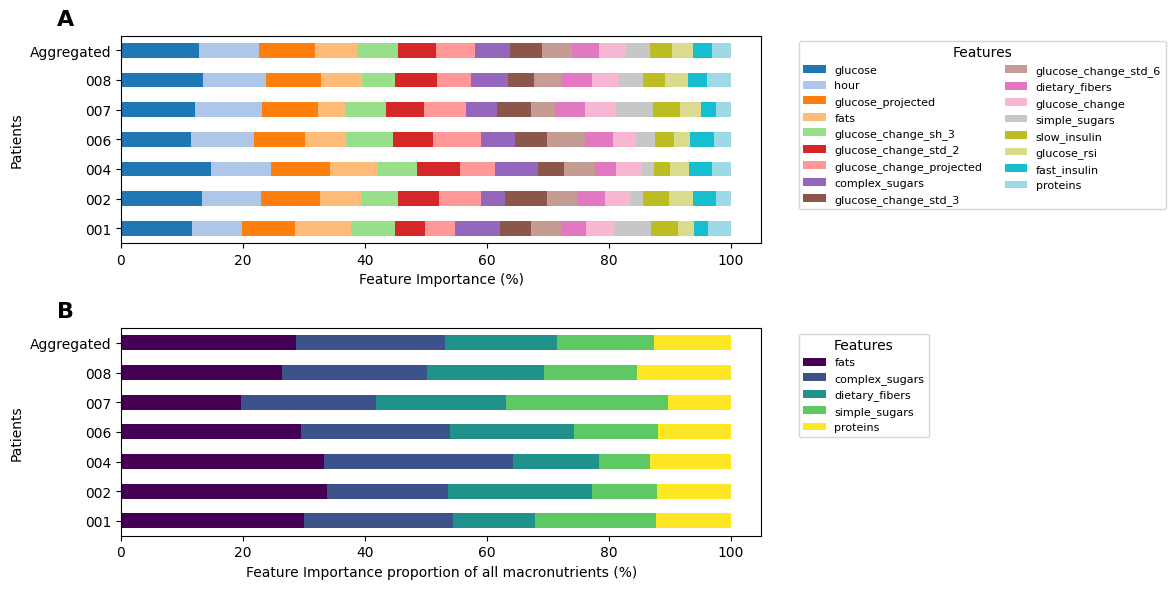

In [139]:
prediction_horizon = 6
model_path = f"models/gpt4o/{prediction_horizon}_1_{patient}.joblib"
model = joblib.load(model_path)
importances_df = pd.DataFrame(index=model.feature_name_)

patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    model_path = f"models/gpt4o/{prediction_horizon}_1_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df[patient] = model.feature_importances_

# Normalize importances
importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
importances_df['Aggregated'] = importances_df.mean(axis=1)
importances_df = importances_df.sort_values(by='Aggregated', ascending=False)

# Prepare data for the second plot
combined_importances = pd.DataFrame()
features_of_interest = ['dietary_fibers', 'simple_sugars', 'fats', 'complex_sugars', 'proteins']

for feature in features_of_interest:
    combined_importances[feature] = importances_df.loc[feature]

combined_importances = combined_importances.transpose()
combined_importances['Aggregated'] = combined_importances.sum(axis=1)
combined_importances = combined_importances.sort_values(by='Aggregated', ascending=False)

normalized_importances = combined_importances.div(combined_importances.sum(axis=0), axis=1) * 100

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# First plot
importances_df.T.plot(kind='barh', stacked=True, colormap='tab20', ax=axes[0])
axes[0].set_xlabel('Feature Importance (%)')
axes[0].set_ylabel('Patients')
axes[0].legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold')

# Second plot
normalized_importances.T.plot(kind='barh', stacked=True, colormap='viridis', ax=axes[1])
axes[1].set_xlabel('Feature Importance proportion of all macronutrients (%)')
axes[1].set_ylabel('Patients')
axes[1].legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold')

plt.savefig(f'paper_images/feature_importances_{approach}.eps', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [142]:
# Calculate total importance of meal features
meal_features = ['fats', 'dietary_fibers', 'simple_sugars', 'complex_sugars', 'proteins']
meal_importances = importances_df.loc[meal_features]
total_meal_importance = meal_importances.sum()

print("Total percentage of meal features importance:")
print(f"{total_meal_importance}")
print(f"Average across patients: {total_meal_importance['Aggregated']:.2f}%")

Total percentage of meal features importance:
001           30.391367
002           20.037807
004           23.193577
006           22.792289
007           22.797767
008           25.726208
Aggregated    24.156502
dtype: float64
Average across patients: 24.16%


In [141]:
importances_df.drop(['glucose', 'glucose_projected', 'glucose_change_projected', 'glucose_change_std_2', 'glucose_change_std_3', 'glucose_change_std_6', 'glucose_change_sh_3', 'slow_insulin', 'fast_insulin', 'glucose_rsi', 'glucose_change', 'hour'])

,001,002,004,006,007,008,Aggregated
fats,9.131905,6.758034,7.738626,6.716418,4.482010,6.788637,6.935938
complex_sugars,7.424706,4.001260,7.158787,5.597015,5.040323,6.114588,5.889446
dietary_fibers,4.090836,4.725898,3.300624,4.617537,4.885236,4.943027,4.427193
simple_sugars,6.007409,2.142407,1.917930,3.125000,6.032878,3.915904,3.856921
proteins,3.736512,2.410208,3.077609,2.736318,2.357320,3.964051,3.047003


In [31]:
normalized_importances

,001,002,004,006,007,008,Aggregated
fats,26.094891,25.210084,32.971014,29.831144,22.375691,25.365854,26.832838
complex_sugars,24.452555,22.689076,31.159420,23.076923,26.243094,25.365854,25.615704
dietary_fibers,13.138686,28.151261,22.101449,19.887430,25.690608,21.951220,21.725675
proteins,16.605839,9.453782,10.869565,12.945591,12.983425,14.634146,13.036446
simple_sugars,19.708029,14.495798,2.898551,14.258912,12.707182,12.682927,12.789338


In [32]:
highest_macronutrient_per_column = normalized_importances.idxmax()  
highest_macronutrient_per_column  

001                     fats
002           dietary_fibers
004                     fats
006                     fats
007           complex_sugars
008                     fats
Aggregated              fats
dtype: object

## Change in feature importances over different prediction horizons

In [36]:
model_path = f"models/gpt4o/{prediction_horizon}/1_{patient}.joblib"
model = joblib.load(model_path)
importances_df = pd.DataFrame(index=model.feature_name_)

patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    model_path = f"models/gpt4o/{prediction_horizon}/1_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df[patient] = model.feature_importances_

# Normalize importances
importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
importance_sums = importances_df.sum(axis=1)
repeated_elements = [item for item in importance_sums.index for _ in range(3)]


ph_importances_df = pd.DataFrame({'PH': [6, 9, 12]*len(importance_sums), 'Feature': repeated_elements, 'Importance': 0.0, 'SD': 0.0})
for prediction_horizon in ['6', '9', '12']:
    model_path = f"models/gpt4o/{prediction_horizon}/1_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df = pd.DataFrame(index=model.feature_name_)

    patients = ['001', '002', '004', '006', '007', '008']
    for patient in patients:
        model_path = f"models/gpt4o/{prediction_horizon}/1_{patient}.joblib"
        model = joblib.load(model_path)
        importances_df[patient] = model.feature_importances_

    # Normalize importances
    importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
    importance_means = importances_df.mean(axis=1)
    importance_stds = importances_df.std(axis=1)
    for feature in importance_means.index:
        ph_importances_df.loc[(ph_importances_df['PH']==int(prediction_horizon)) & (ph_importances_df['Feature']==feature), 'Importance'] = importance_means[feature]
        ph_importances_df.loc[(ph_importances_df['PH']==int(prediction_horizon)) & (ph_importances_df['Feature']==feature), 'SD'] = importance_stds[feature]

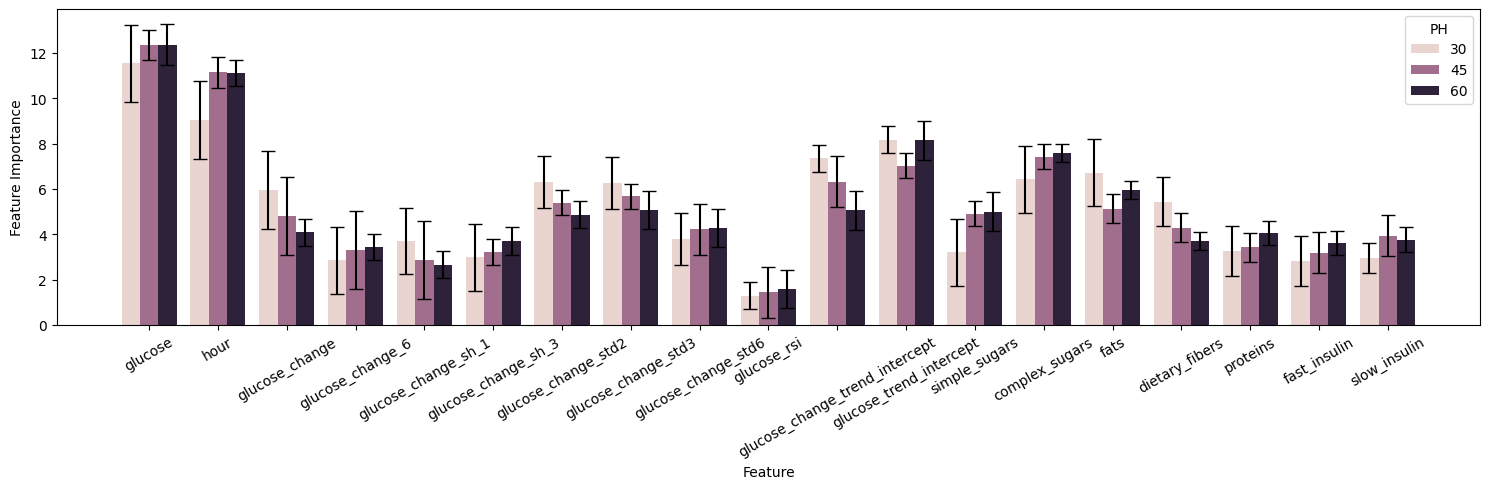

In [37]:
# Plotting the barplot with error bars
ph_importances_df['PH'] *= 5
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='Feature', y='Importance', hue='PH', data=ph_importances_df)

# Add standard error bars
for i, bar in enumerate(ax.patches):
    # Get the center of each bar
    x = bar.get_x() + bar.get_width() / 2
    height = bar.get_height()
    
    # Retrieve the corresponding standard deviation (SD) for the error bar
    std = ph_importances_df.iloc[i // 3]['SD']  
    
    # Add the error bar
    if height != 0:
        ax.errorbar(x=x, y=height, yerr=std, fmt='none', c='black', capsize=5)

plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.xticks(rotation=30)
plt.legend(title='PH')
plt.tight_layout()
plt.show()

In [38]:
highest_phs = []
for feature in ph_importances_df.Feature.unique():
    selected_df = ph_importances_df[ph_importances_df['Feature']==feature]
    highest_ph = selected_df.loc[selected_df['Importance']==selected_df['Importance'].max(), 'PH'].values[0]
    highest_phs.append(highest_ph)

feature_most_impact_ph_df = pd.DataFrame({'Feature': ph_importances_df.Feature.unique(), 'PH': highest_phs})

In [39]:
ph_importances_df

,PH,Feature,Importance,SD
0,30,glucose,11.536643,1.711181
1,45,glucose,12.349173,1.467353
2,60,glucose,12.358188,1.151992
3,30,hour,9.027160,0.604711
4,45,hour,11.138057,1.471997
5,60,hour,11.103670,1.087505
6,30,glucose_change,5.961834,0.670087
7,45,glucose_change,4.788401,1.721601
8,60,glucose_change,4.082319,0.559551
9,30,glucose_change_6,2.845830,1.127200


In [40]:
for ph in [6, 9, 12]:
    features_at_ph = feature_most_impact_ph_df.loc[feature_most_impact_ph_df['PH']==ph, 'Feature'].values
    print(f'Features that have highest impact at PH {ph*5}: {features_at_ph}')

Features that have highest impact at PH 30: []
Features that have highest impact at PH 45: []
Features that have highest impact at PH 60: []


## Visualize feature mapping over time 

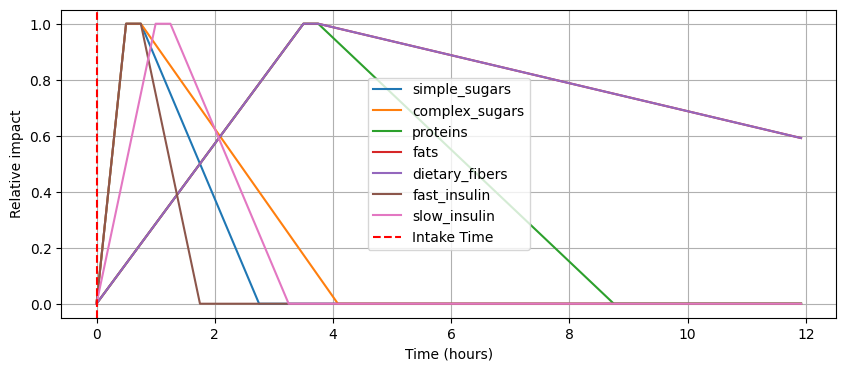

In [25]:
feature_params = {
    'simple_sugars': [0.5, 0.5],  # [insulin_sensitivity_param, peak_time]
    'complex_sugars': [0.3, 0.5],
    'proteins': [0.2, 3.5],
    'fats': [0.05, 3.5], 
    'dietary_fibers': [0.05, 3.5],
    'fast_insulin': [1.0, 0.5], 
    'slow_insulin': [0.5, 1.0]
}

times = np.arange(0, 12, (1/12))
intake_time = 0

glucose_data = pd.DataFrame({'Time': times})

for feature, param in feature_params.items():
    time_diff_hours = times - intake_time
    metabolism_rate, peak_time = param[0], param[1]
    plateau_duration = 0.25
    
    weights = np.zeros_like(time_diff_hours)

    # Linear increase (before the peak)
    increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
    weights[increase_mask] = time_diff_hours[increase_mask] / peak_time

    # Plateau (at the peak)
    plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
    weights[plateau_mask] = 1

    # Linear decrease (after the plateau)
    decrease_mask = (time_diff_hours >= peak_time + plateau_duration)
    weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration))*metabolism_rate
    weights = np.clip(weights, 0, np.inf) 
    glucose_data[feature] = weights

plt.figure(figsize=(10, 4))
for feature in feature_params.keys():
    plt.plot(glucose_data['Time'], glucose_data[feature], linestyle='-', label=feature)

plt.axvline(x=intake_time, color='r', linestyle='--', label='Intake Time')

plt.xlabel('Time (hours)')
plt.ylabel('Relative impact')
plt.legend()
plt.grid(True)
plt.show()

## Differences in macronutrient estimation between LLMs

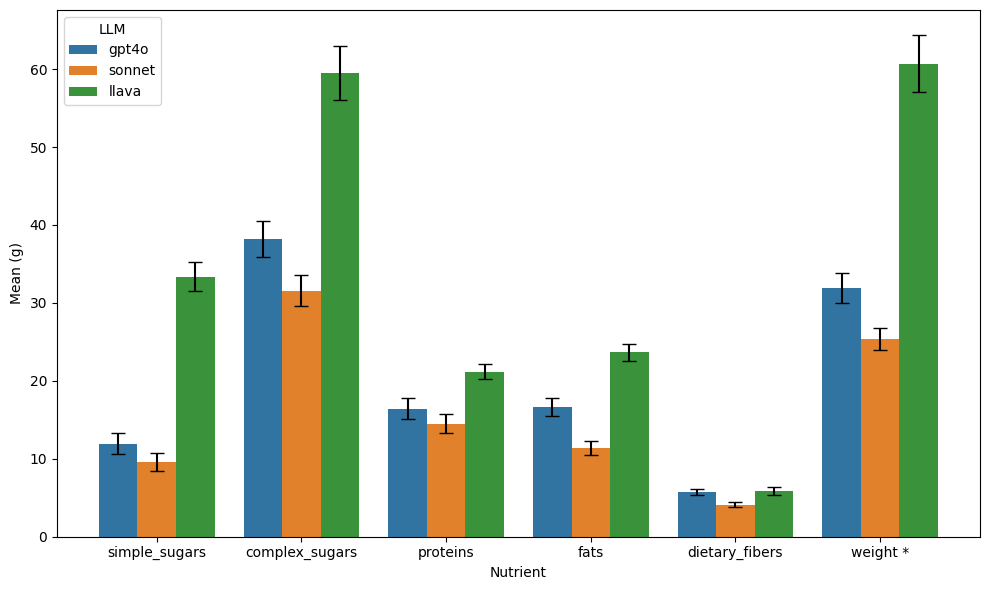

In [29]:
approaches = ['gpt4o', 'sonnet', 'llava']

data = {approach: [] for approach in approaches}

# Load the data
for approach in approaches:
    for patient in patients:
        food_data = pd.read_csv(f'food_data/{approach}/{patient}.csv')
        data[approach].append(food_data)

# Compute the mean and standard error for each approach
results = {'Approach': [], 'Nutrient': [], 'Mean': [], 'Std Error': []}
nutrients = ['simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers', 'weight *']

for approach, dfs in data.items():
    combined_df = pd.concat(dfs)
    combined_df['weight *'] = combined_df['weight'] / 10
    for nutrient in nutrients:
        mean_value = combined_df[nutrient].mean()
        std_error = combined_df[nutrient].sem()
        results['Approach'].append(approach)
        results['Nutrient'].append(nutrient)
        results['Mean'].append(mean_value)
        results['Std Error'].append(std_error)

results_df = pd.DataFrame(results)

# Plotting the data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Nutrient', y='Mean', hue='Approach', data=results_df, errorbar=None, capsize=0.1)

# Add standard error bars
num_approaches = len(approaches)
bar_width = 0.8 / num_approaches 
for i, approach in enumerate(approaches):
    approach_data = results_df[results_df['Approach'] == approach]
    x_positions = np.arange(len(nutrients)) - 0.4 + bar_width/2 + i * bar_width
    plt.errorbar(x=x_positions, y=approach_data['Mean'], yerr=approach_data['Std Error'], fmt='none', c='black', capsize=5)

plt.xlabel('Nutrient')
plt.ylabel('Mean (g)')
plt.legend(title='LLM')
plt.tight_layout()
plt.show()

## Determine performance when forecasting hypo- and hyperglycemia

In [61]:
approach = 'gpt4o'
prediction_horizon = 6
patient = '004'
preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_preds.csv")

In [62]:
# Calculate glucose at prediction horizon by adding ground truth to initial glucose
preds['Glucose_at_PH'] = preds['Initial_glucose'] - preds['Ground_truth']
preds['Predicted_Glucose_at_PH'] = preds['Initial_glucose'] - preds['Predictions']

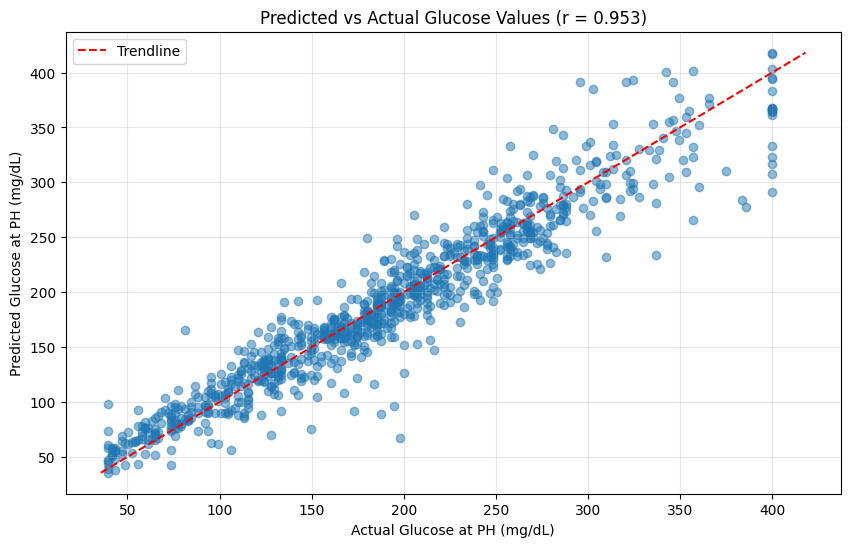

In [69]:
# Calculate correlation coefficient
corr_coef = preds['Glucose_at_PH'].corr(preds['Predicted_Glucose_at_PH'])

plt.figure(figsize=(10, 6))
plt.scatter(preds['Glucose_at_PH'], preds['Predicted_Glucose_at_PH'], alpha=0.5)
plt.xlabel('Actual Glucose at PH (mg/dL)')
plt.ylabel('Predicted Glucose at PH (mg/dL)')
plt.title(f'Predicted vs Actual Glucose Values (r = {corr_coef:.3f})')

# Add diagonal line representing perfect predictions
min_val = min(preds['Glucose_at_PH'].min(), preds['Predicted_Glucose_at_PH'].min())
max_val = max(preds['Glucose_at_PH'].max(), preds['Predicted_Glucose_at_PH'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Trendline')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()